In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
#from torch.autograd import Variable
print(torch.__version__)

0.4.0


In [2]:
import pickle

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [277]:
class ConvPID(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_ECAL = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, 256)
        )
        self.conv_HCAL = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, 256)
        )
        self.conv_MUON = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, 256)
        )
        
        self.dense = nn.Linear(512, 512)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(512, 3)
        
    def forward(self, pics):
        ecal_dense = self.conv_ECAL(pics[:, :1])
        #hcal_dense = self.conv_HCAL(pics[:, 1:3])
        muon_dense = self.conv_MUON(pics[:, 1:])
        
        #ecal_full = torch.cat([ecal])
        
        out = torch.cat([ecal_dense, muon_dense], dim=-1)
        
        #print(out.shape)
        return self.output(self.dropout(self.dense(out)))

In [265]:
def read_file(filename):
    with open("DET_RESPONDS/1_20_ALL/" + filename, 'rb') as f:
        responses = pickle.load(f, encoding='latin1')
    
    
    det_responses = np.zeros((len(responses), 5, 20, 20))
    momentum = np.zeros((len(responses), 3))
    labels = np.ones(len(responses))
    
    if "mu" in filename:
        labels *= 0
    elif "had" in filename:
        labels *= 2
    
    index = 0
    for key, value in responses.items():
        det_responses[index, 0] = value['ECAL'][0]

        #det_responses[index, 1:3] = value['H#CAL'][0]

        det_responses[index, 1:] = value['MUON'][0]

        for det_i, det in enumerate(['ECAL', 'HCAL', 'MUON']):
            mom = value[det][1]
            mom = mom if mom is not None else -1
            momentum[index, det_i] = mom

        index += 1
    return det_responses, momentum, labels

In [266]:
X_data = None
y_data = None

In [248]:
#list_of_file = ['ele.pkl', 'mu_5.pkl', 'mu_8.pkl']
#list_of_file = ['had.pkl', 'ele.pkl', 'mu_5.pkl', 'mu_8.pkl', 'mu_1.5.pkl', 'mu_3.pkl']
list_of_file= ['ele.pkl', 'had.pkl', 'mu.pkl']

In [249]:
!ls DET_RESPONDS/1_20_ALL/

ele.pkl  had.pkl  mu.pkl


In [250]:
for filename in list_of_file:
    responses, momentum, label = read_file(filename)
    empty_events_ind = (responses == 0).all(axis=(1,2,3))
    print("Len of empty pics events: {}".format(empty_events_ind.sum()))
    print("N event with -1 momentum: {}".format((momentum == -1).all(axis=-1).sum()))
    
    responses, momentum, label = responses[~empty_events_ind], momentum[~empty_events_ind],\
                                 label[~empty_events_ind]
    if X_data is None:
        X_data = responses
        y_data = label
        m_data = momentum
    else:
        X_data = np.vstack((X_data, responses))
        y_data = np.hstack((y_data, label))
        m_data = np.vstack((m_data, momentum))

Len of empty pics events: 23
N event with -1 momentum: 23
Len of empty pics events: 28
N event with -1 momentum: 28
Len of empty pics events: 22
N event with -1 momentum: 22


In [251]:
print((y_data == 0).sum())
print((y_data == 1).sum())
print((y_data == 2).sum())

2978
2977
2956


In [252]:
from sklearn.model_selection import train_test_split

In [253]:
X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(X_data, y_data, m_data,
                                                                  test_size=0.1, random_state=1543)

In [254]:
for index in range(3):
    print((y_val == index).sum())

273
298
321


In [288]:
print(X_train.shape, X_val.shape)

(8019, 5, 20, 20) (892, 5, 20, 20)


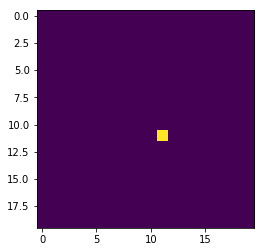

In [257]:
plt.imshow(X_data[8000, 2])

#  Train net

In [282]:
from tqdm import trange
def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [283]:
model = ConvPID()

In [284]:
import time
from pandas import ewma
from IPython import display        
        
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 40
batch_size = 128

train_loss = []
val_accuracy = []

In [292]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4 / 2)

In [285]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.FloatTensor(X_batch).to(device)
    y_batch = torch.LongTensor(y_batch).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

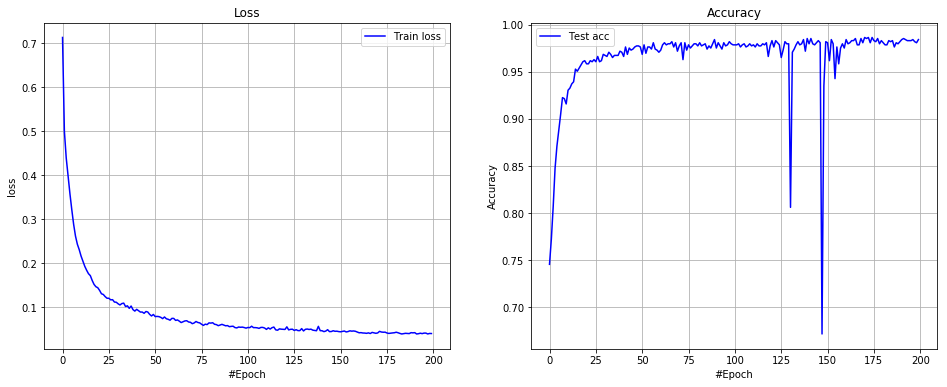

Epoch 40 of 40 took 2.206s
  training loss (in-iteration): 	0.040567
  validation accuracy:		98.43 %


In [293]:
device = torch.device("cpu")

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True)
    
    epoch_loss = 0
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_loss += loss.item()
        
    train_loss.append(epoch_loss / (len(X_train) // batch_size + 1))
        
        
    y_score = []
    with torch.no_grad():
        model.train(False)
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            logits = model(torch.FloatTensor(X_batch).to(device))
            y_pred = logits.max(dim=1)[1].detach().numpy()
            #val_accuracy.append(np.mean(y_batch == y_pred))
            y_score.extend(y_pred)
    
    y_score = np.asarray(y_score)
    val_accuracy.append(np.mean(y_score == y_val))
    # Visualize
    
    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.set_title("Loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(train_loss, 'b', label='Train loss')
    #ax1.plot(ewma(train_loss, span=10), 'r', label='ewma')
    #ax1.plot(ewma(np.array(train_loss), span=10),'r',label='ewm val loss')
    ax1.legend(loc='best')
    ax1.grid()

    ax2.set_title("Accuracy")
    ax2.set_xlabel("#Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(val_accuracy, 'b', label='Test acc')
    #ax2.plot(ewma(val_accuracy, span=10), 'r', label='test ewma')
    #ax2.plot(ewma(np.array(val_loss), span=10),'r',label='ewm val acc')
    ax2.legend(loc='best')
    ax2.grid()    

    plt.show()
            
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        train_loss[-1]))
    print("  validation accuracy:\t\t{:.2f} %".format(val_accuracy[-1] * 100))

In [294]:
model.eval()
predictions = model(torch.FloatTensor(X_val).to(device)).max(dim=1)[1].detach().numpy()

In [295]:
np.mean((predictions == y_val))

0.984304932735426

In [296]:
y_val.shape

(892,)

In [232]:
(y_val == 2).sum()

48

In [297]:
from collections import Counter
count = Counter()

In [298]:
count.update(y_val[(predictions != y_val)])

In [299]:
count

Counter({0.0: 7, 1.0: 3, 2.0: 4})

In [300]:
misident_ind = np.where(predictions != y_val)[0]
misident_ind

array([ 46,  55,  67,  76, 216, 290, 540, 591, 603, 694, 698, 713, 717,
       823])

In [302]:
index = 823

In [219]:
# initially_zero_evnts = (X_val[misident_ind, ...] == 0).all(axis=(1,2,3))
# print(initially_zero_evnts.sum())
# initially_zero_evnts

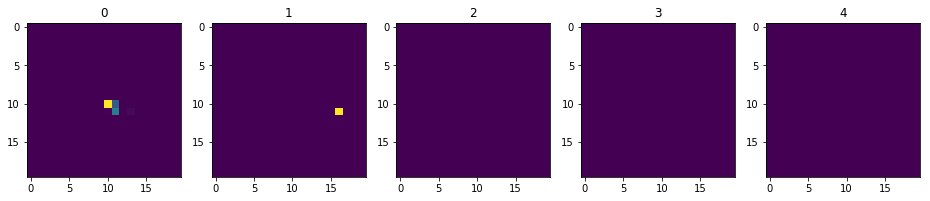

In [312]:
f, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,12))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_val[index, i])
    ax.set_title(str(i))

In [313]:
predictions[index]

2

In [314]:
y_val[index]

0.0

In [315]:
F.softmax(model(torch.FloatTensor(X_val).to(device))[index], dim=0)

tensor([ 4.5228e-04,  1.5851e-07,  9.9955e-01])

In [316]:
m_val[index]

array([2.00583892, 1.85546102, 1.85546102])